In [225]:
import pandas as pd
import numpy as np
import re
import os

import trmc.load as load
import trmc.analysis as analysis
import trmc.plot as plot
from trmc.plot import exp_formatter

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter, FuncFormatter
%matplotlib inline

import xarray as xr

from IPython.display import clear_output
from collections import OrderedDict
import itertools

In [226]:
# basedir = '\\\\depot.engr.oregonstate.edu\\users\\coe_apirate\\Windows.Documents\\Desktop\\Data'
basedir = 'C:\\Users\\aspit\\OneDrive\\OSU\\Raw Data'
# basedir = 'C://Users/coe_apirate/OneDrive/Data/TRMC/Raw Data'
fps = {
    'bid_3': os.path.join(basedir,'20190302\EPFL_D2_3'),
    'bic_3': os.path.join(basedir,'20190301\EPFL_Bi_C2_3'),
    'pc': os.path.join(basedir,'20190228\EPFL_PC_2'),
    'kcs': os.path.join(basedir,'20190227\EPFL_KCS_2'),
    'k': os.path.join(basedir,'20190226\EPFL_2_K_2'),
    'n': os.path.join(basedir,'20190226\EPFL_2_N_2'),
    'cs': os.path.join(basedir,'20190225\EPFL_2_C_2'),
#     'ox1ns': os.path.join(basedir,'20190224\Ox1ns'),
#     'ox1s': os.path.join(basedir,'20190224\Ox1s'),
#     'ox1ns2': os.path.join(basedir,'20190224\Ox1ns2'),
#     'bia': os.path.join(basedir,'20190128\Bi_A_2'),
#     'bid': os.path.join(basedir,'20190201\Sample_D_2'),
#     'bic': os.path.join(basedir,'20190130\Sample Bi_C_2_2'),
#     'bib': os.path.join(basedir,'20190202\Sample Bi_B_2'),
#     'bhjua': os.path.join(basedir,'20190125\PH3TUA'),
#     'bhja': os.path.join(basedir,'20190127\P3HTA')   
}

In [227]:
# da_sw = load.sweeps2ds(fps)['Vsignal(V)']

## load in and plot the deltaV data sets

In [228]:

timefactor = {'bia': 2, 'bic' : 2}
timeshifts = {'bia': -450e-9, 'bic': -450e-9,'bhjua': -270e-9,'bhja': -270e-9, 'bid': -270e-9,'bib': -270e-9}

#corect for incorrect data entry, most are right
fluencefactor = {
    'bia': 5.53665E+14/5.53665E+14,
    'bid': 4.21267E+14/4.213E+14,
    'bic': 5.29593E+14/3.611E+14,
    'bib': 3.852E+14/3.852E+14,
}

In [229]:
das = []
das_bv = []

for samp in fps:
    direc = os.path.join(fps[samp],'FreqFluence')
    s_fps = load.freqfluence_flist(direc)
    print('Loading data for ' + samp)
    s,backvs = load.freqfluence_load(s_fps)
    print('Converting to Dataset')
    da = xr.DataArray.from_series(s)
    da = da.chunk({'time': 2000})
    da = da.expand_dims('sample')
    da['sample'] = [samp]
    
    if samp in timefactor:
#         print('shifting time for ' + samp + " by " + str(timeshifts[samp]))
        print('scaling time for ' + samp + " by " + str(timefactor[samp]))
        timearr = da.indexes['time']
        da = da.assign_coords(time =  timearr*timefactor[samp])

    if samp in timeshifts:
        print('shifting time for ' + samp + " by " + str(timeshifts[samp]))
        timearr = da.indexes['time']
        da = da.assign_coords(time =  timearr+timeshifts[samp])
        
    if samp in fluencefactor:
        print('Multiplying fluence of ' + samp + " by " + str(fluencefactor[samp]))
        fluencearr = da.indexes['fluence']
        da = da.assign_coords(fluence =  fluencearr*fluencefactor[samp])
    
    das.append(da)
    
    da_bv = xr.DataArray.from_series(backvs)
    da_bv = da_bv.expand_dims('sample')
    da_bv['sample'] = [samp]
    das_bv.append(da_bv)

da_dv = xr.concat(das, dim = 'sample')
da_dv = da_dv*(-1) #voltage is flipped

da_dv.name = '$\Delta V$ (V)'
da_dv.attrs = dict(units = 'V', long_name = '$\Delta V$')

da_dv.coords['freq'].attrs = dict(units = 'Hz', long_name = 'Frequency')
da_dv.coords['fluence'].attrs = dict(units = '$\#/cm^2/pulse$', long_name = 'Fluence')
da_dv.coords['time'].attrs = dict(units = 'ns', long_name = 'Time')

da_bv = xr.concat(das_bv,dim = 'sample')

print('done')

no match for file TestSweep_psm_image.png
Loading data for cs
Converting to Dataset
done


In [230]:
das = []
for samp in fps:
    direc = os.path.join(fps[samp],'FreqFluence')    
    fpsdcs = load.freqdcs_flist(direc)
    
    for direction,freqt in fpsdcs.index:
        fp = fpsdcs.loc[direction,freqt]
        s = load.loadsweep(fp,defaultV = 0.025)
        s = s.rename(s.name.replace(' ', ''))
        s.index = s.index.rename('freq')
        da = xr.DataArray.from_series(s)
        da = da.assign_coords(direction = direction).expand_dims('direction')
        da = da.assign_coords(freqt = freqt).expand_dims('freqt')
        da = da.assign_coords(sample = samp).expand_dims('sample')
        das.append(da)
    
da_dcs = xr.merge(das)['Vsignal(V)']

da_dcs.name = '$V_r$ (V)'
da_dcs.attrs = dict(units = 'V', long_name = '$V_r$')

da_dcs.coords['freq'].attrs = dict(units = 'Hz', long_name = 'Frequency')
da_dcs.coords['freqt'].attrs = dict(units = 'Hz', long_name = 'Set Frequency')

In [231]:
%store da_dv
%store da_bv
# %store da_sw
%store da_dcs

Stored 'da_dv' (DataArray)
Stored 'da_bv' (DataArray)
Stored 'da_dcs' (DataArray)


## Plot raw data

In [232]:
da_dv = da_dv.load()

In [233]:
col = None if (len(da_dv.indexes['sample']) == 1)  else 'sample'
row = None if (len(da_dv.indexes['direction']) == 1)  else 'direction'
timeslice = slice(0e-9,1000e-9)

C:\Users\aspit\Anaconda3\envs\py36\lib\site-packages\xarray\core\nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


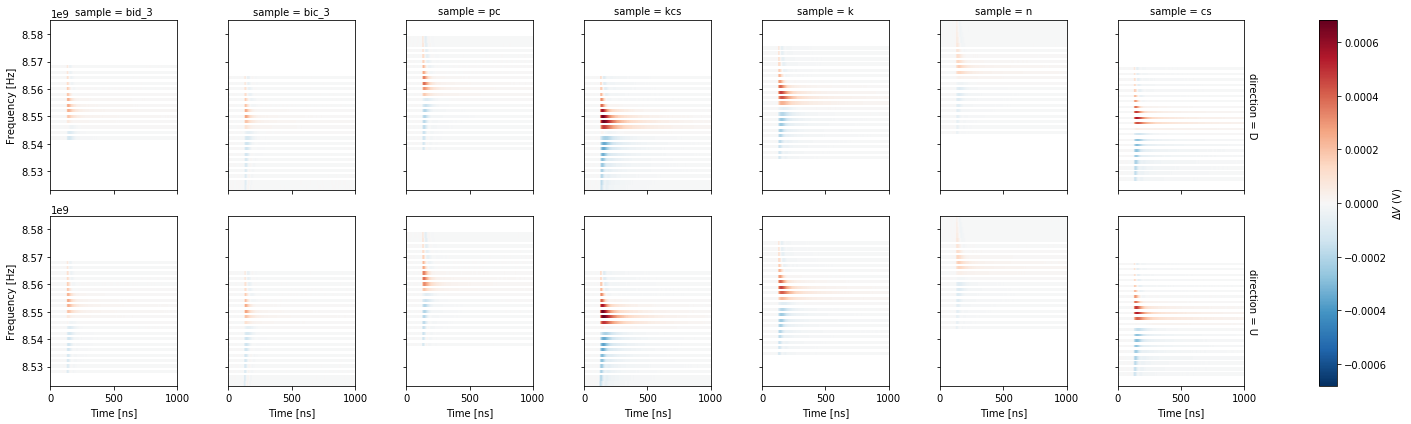

In [234]:
g = da_dv.dropna('fluence','all').mean('fluence').sel(time = timeslice).plot(x = 'time', y = 'freq', row = row, col = col)

axs = g.axes.flatten() if type(g.axes) == np.ndarray else [g.axes]
for ax in axs:
    ax.xaxis.set_major_formatter(FuncFormatter(plot.exp_formatter(-9).func))

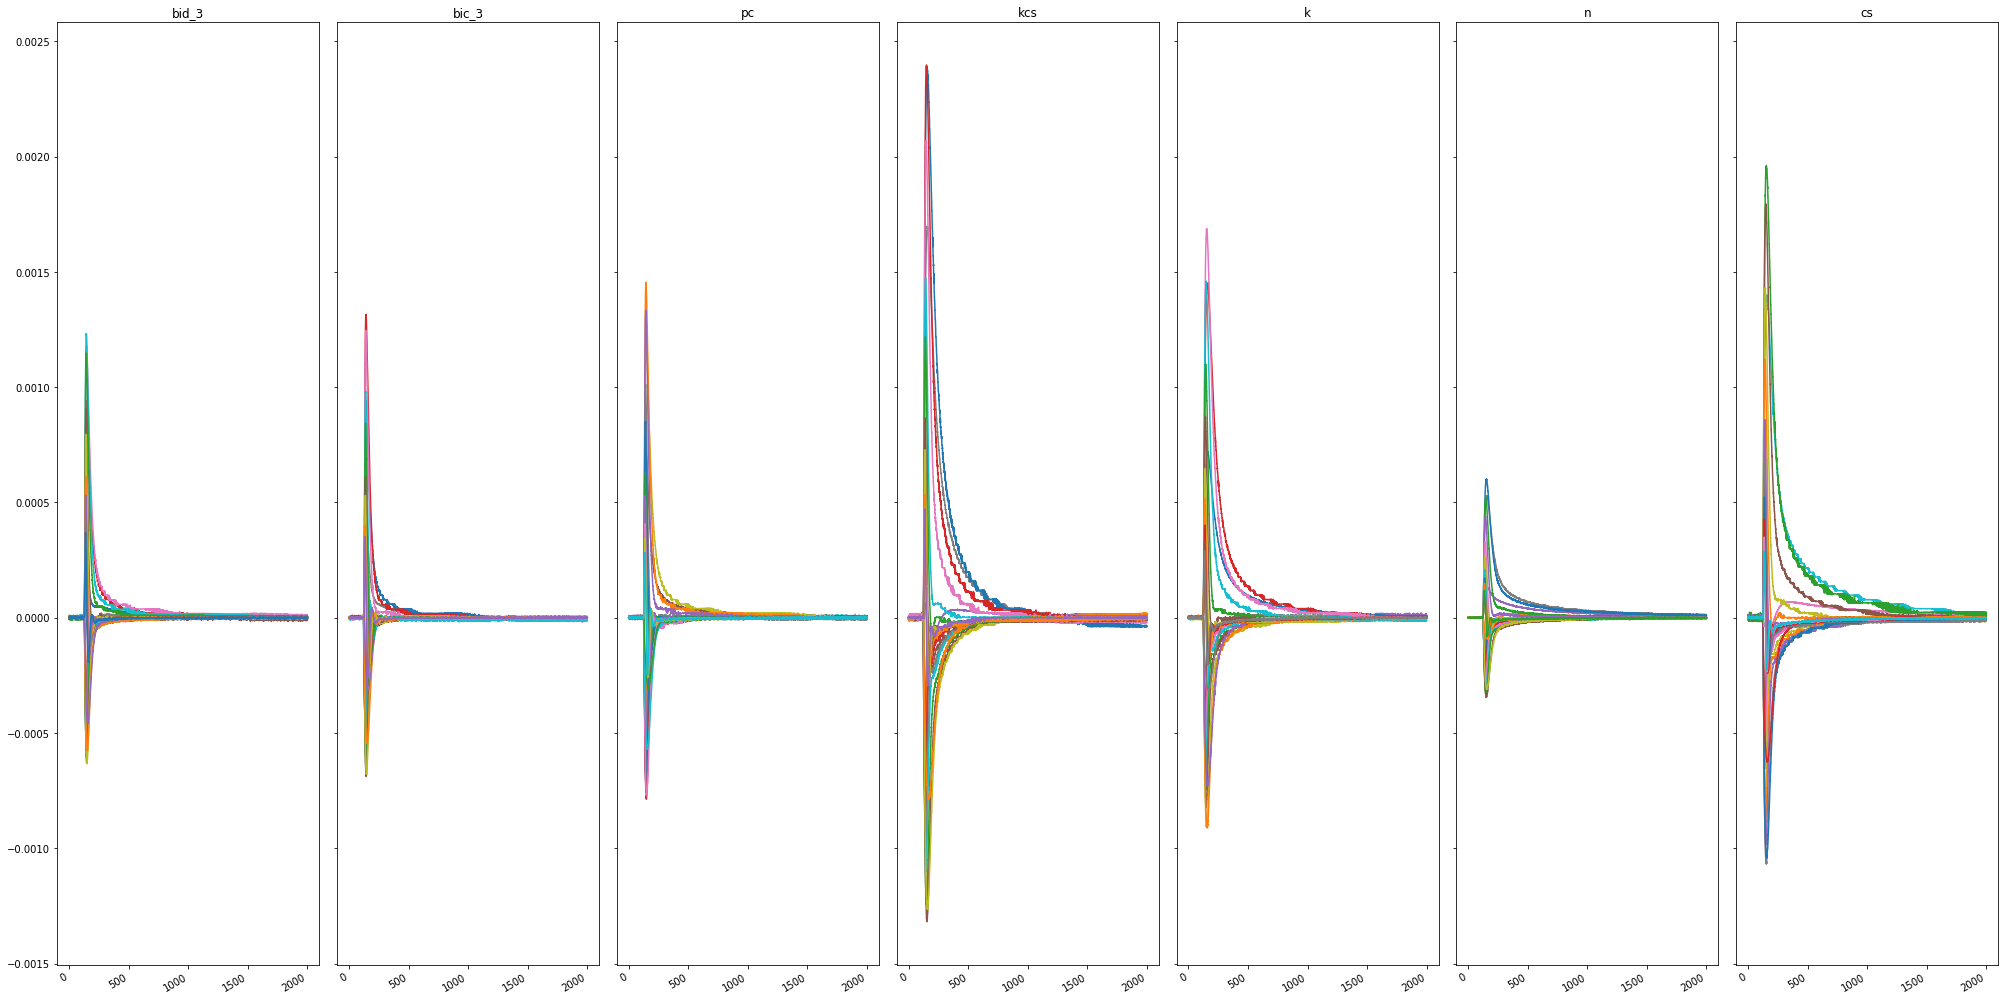

In [235]:
size = len(da_dv.indexes['sample'])
fig, axes = plt.subplots(1,size, figsize = (4*size, 2*size), squeeze=False, sharey = True)

for i,samp in enumerate(da_dv.indexes['sample']):
    data = da_dv.sel(sample = samp).sel(direction = 'U').dropna('fluence','all').isel(fluence = -1).dropna('time','all')
    ax = axes[0][i]
    f0 = 8.542e9
    freqs = data.indexes['freq']
    for freq in freqs:
        trace = data.sel(freq = freq).dropna('time','all')
        ax.plot(trace.to_series())
#     ax = plot.redbluetransient(ax,data, f0)
    ax.set_title(samp)
#     ax.set_xlim([200e-9,2000e-9])
#     ax.set_xlabel('time (ns)')
#     ax.set_ylabel('Voltage (V)')
    ax.xaxis.set_major_formatter(FuncFormatter(plot.exp_formatter(-9).func))

# ax.legend()
fig.autofmt_xdate()
fig.tight_layout()

## Normalized Delta V 

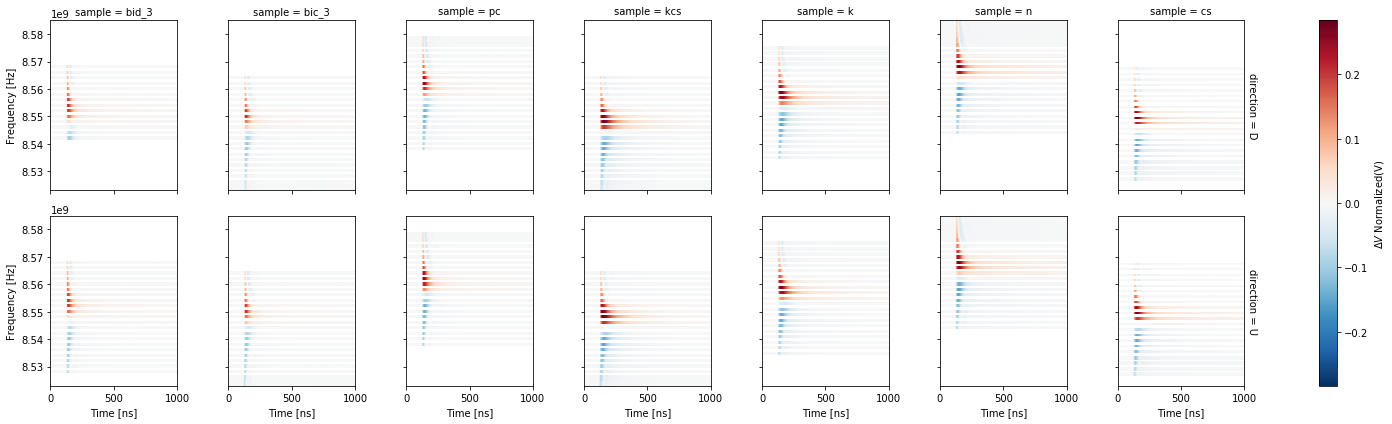

In [236]:
def norm(x):
    return x/x.max()

da_dv_norm = da_dv.groupby('sample').apply(norm)
da_dv_norm.name = '$\Delta V$ Normalized(V)'

g = da_dv_norm.dropna('fluence','all').mean('fluence').sel(time = timeslice).plot(x = 'time', y = 'freq', row = row, col = col)

axs = g.axes.flatten() if type(g.axes) == np.ndarray else [g.axes]
for ax in axs:
    ax.xaxis.set_major_formatter(FuncFormatter(plot.exp_formatter(-9).func))

## plot the dark cavity sweeps

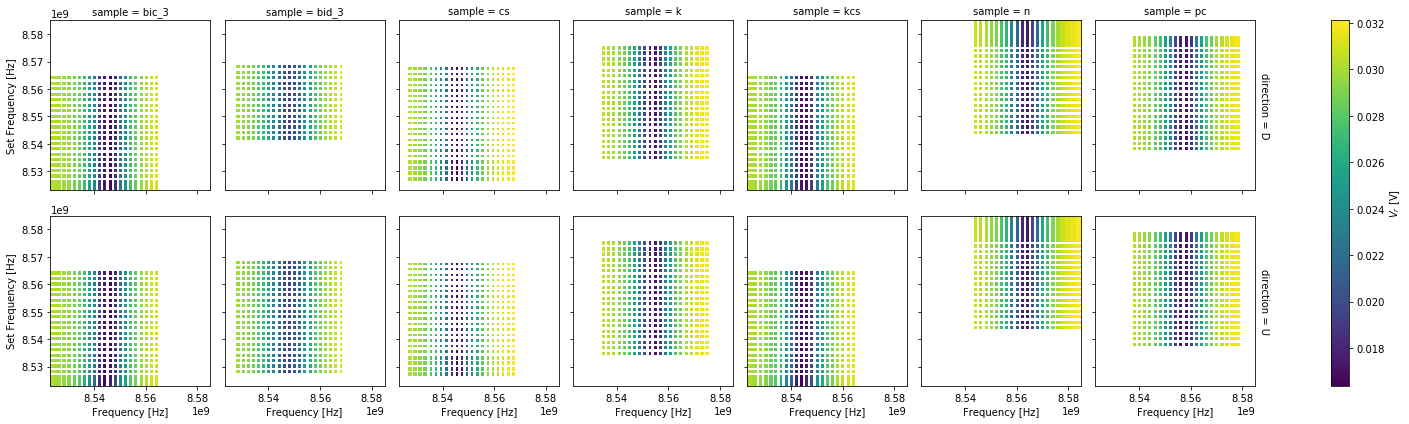

In [237]:
da_dcs.plot(x = 'freq',y='freqt',row = row,col = col)

bic_3
bid_3
cs
k
kcs
n
pc
bic_3
bid_3
cs
k
kcs
n
pc


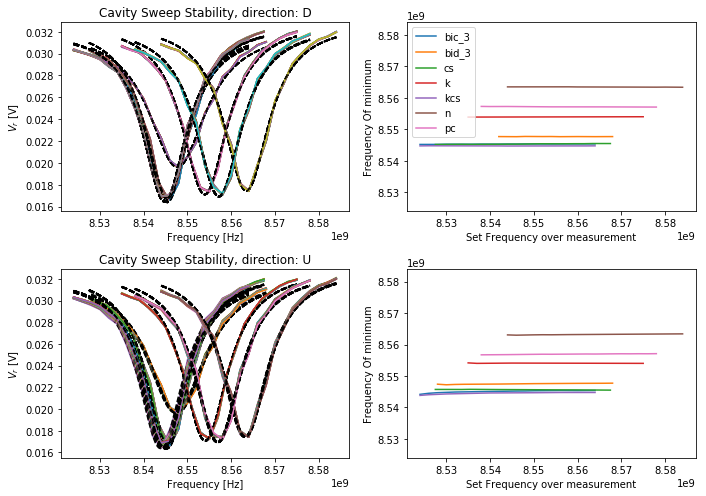

In [238]:
p_labels = ['f0','w','R','Rinf'] 
epsilon = 0.00001
bounds = ([0,0,0, 0],[np.inf,np.inf,np.inf, np.inf])
window = 100

fig, axes = plt.subplots(2,2, figsize = (10,7))

for i, direc in enumerate(da_dcs.indexes['direction']):
    daf0s = []
    for samp in da_dcs.indexes['sample']:
        print(samp)
        da = da_dcs.sel(sample = samp).sel(direction = direc).dropna('freq','all').dropna('freqt','all')
        f0s = []
        for freqt in da.indexes['freqt']:
            d = da.sel(freqt = freqt)
            d.plot(ax = axes[i][0])

            Rinf = 0.02125
            f0 = d.to_series().idxmin()
            p0 =[f0,0.01,Rinf,1e7 ]

            v0_fit, v0_p,v0_sl = analysis.fitsweep(d, p0, bounds, window , 'lor',p_labels)
            popt = v0_p[0]
            f0s.append(popt[0])

            freqs = da.indexes['freq']
            freqs_i = np.linspace(freqs.min(),freqs.max(),100)
            dfit = v0_fit(freqs_i)
            dfit = pd.Series(dfit, index = freqs_i)
            axes[i][0].plot(dfit, color = 'black', linestyle = '--')
            

        daf0s.append(xr.DataArray(f0s, coords = {'freqt' : da.indexes['freqt']}, dims= ['freqt']).assign_coords(sample = samp).expand_dims('sample'))


    daf0s = xr.concat(daf0s, dim = 'freqt')

    for samp in daf0s.indexes['sample']:
        axes[i][1].plot(daf0s.sel(sample = samp).to_series(), label = samp)

#     axes[i][0].set_xlabel('Frequency')
#     axes[i][0].set_ylabel('Voltage (V)')

    axes[i][1].legend()
    axes[i][1].set_ylabel('Frequency Of minimum')
    axes[i][1].set_xlabel('Set Frequency over measurement')
    axes[i][0].set_title('Cavity Sweep Stability, direction: ' + direc)
    
    axes[i][1].set_ylim([da_dcs.indexes['freq'].min().item(),da_dcs.indexes['freq'].max().item()])
    
axes[1][1].get_legend().remove()
fig.tight_layout()

In [239]:
#remove from memory
del da_dv

%store -r da_dv